In [2]:
!pip install numpy scipy matplotlib scikit-image
!pip install opencv-python

  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/f3/93/65601f7577d6fd49ec23bf8fb58c04d8170b06a1544452ae2ea9f59bf11f/scikit_image-0.21.0-cp310-cp310-win_amd64.whl.metadata
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/eb/21/662994d78d8623055f8ffa91838e28f04b2a34bd5d8d6dbc6c7573285ed6/imageio-2.31.3-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/12/3e/89513f44a10c625121b7d5bc54390d7ac7f2c92a19755c052888febf9730/tifffile-2023.8.30-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
     --- ------------------------------------ 0.4/4.2 MB 8.3 MB/s eta 0:00:01
     --------- ------------------------------ 1.0/4.2 MB 10.0 MB/s eta 0:00:01
     -------------- ------------------------- 1.5/4.2 MB 12.0 MB/s eta 0:00:0

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.fft import fft2
from scipy.ndimage import gaussian_filter
from skimage.filters import unsharp_mask
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import cv2
import numpy as np


In [4]:
# Create a 2D circular averaging filter (LOW pass)
def fspecial_disk(radius):
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel = np.zeros((2*radius+1, 2*radius+1))
    kernel[mask] = 1
    return kernel / np.sum(mask)


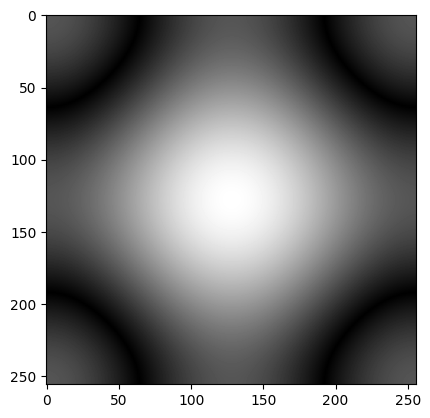

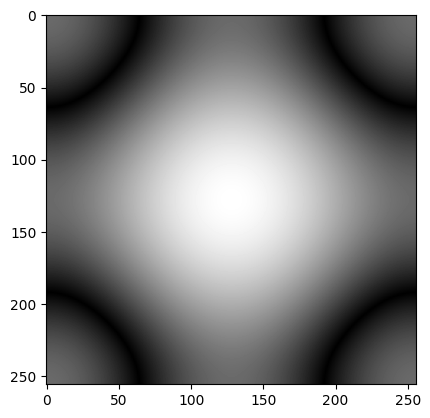

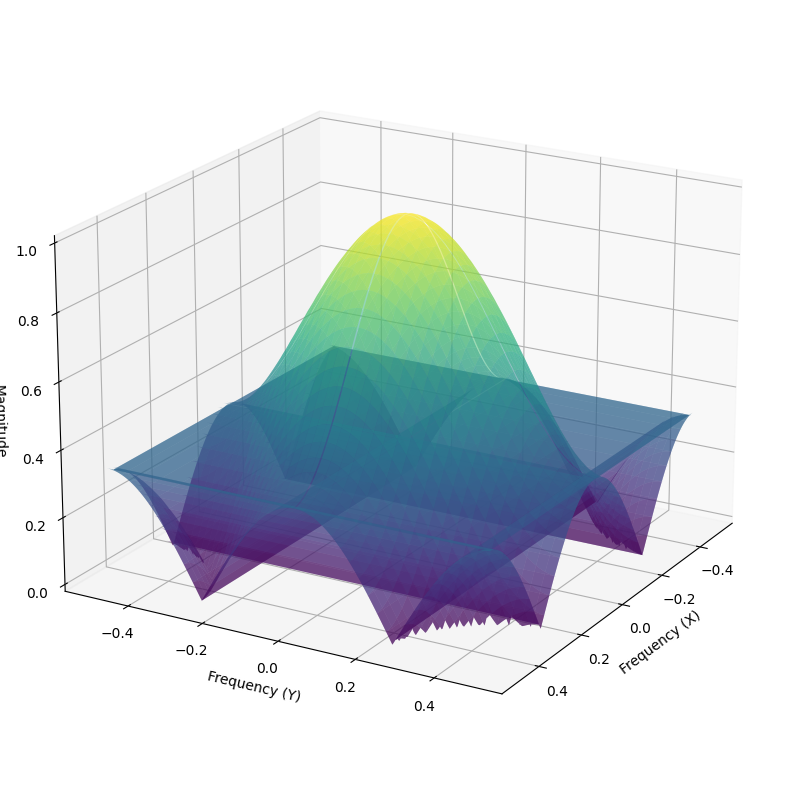

In [16]:


# Parameters
N = 256
big = np.zeros((N, N))
big[N // 2, N // 2] = 1

# Create the circular averaging filter
#h = fspecial_disk(radius=8)
h = np.array([[0, 1/6, 0], [1/6, 1/3, 1/6], [0, 1/6, 0]])  # Custom filter

# Create an unsharp mask kernel, high pass
#h = np.array([[0, -1, 0],
#             [-1, 5, -1],
#              [0, -1, 0]])


# Apply the filter to the image
h1 = cv2.filter2D(big, -1, h)

# Compute the 2D Fourier Transform
S = np.fft.fft2(h1)
SM = np.abs(S)

# Display the spectrum
plt.figure()
plt.imshow(np.fft.fftshift(SM / np.max(SM)), cmap='gray')

# Display the spectrum in log scale
plt.figure()
IMd = np.log(1 + abs(SM))
plt.imshow(np.fft.fftshift(IMd / np.max(IMd)), cmap='gray')

plt.show()

frequencies_x = np.fft.fftfreq(N, 1.0)
frequencies_y = np.fft.fftfreq(N, 1.0)
X, Y = np.meshgrid(frequencies_x, frequencies_y)

fig = plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Frequency (X)')
ax.set_ylabel('Frequency (Y)')
ax.set_zlabel('Magnitude')

z_min = 0
z_max = np.max(SM) 

ax.view_init(elev=20, azim=30) 
ax.set_zlim(z_min, z_max)
ax.plot_surface(X, Y, SM, cmap='viridis', vmin=z_min, vmax=z_max,alpha=0.5)

plt.show()

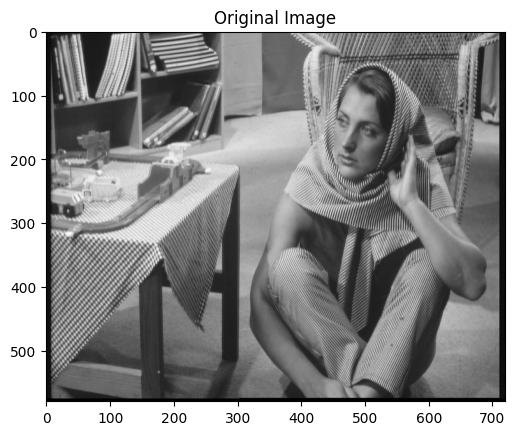

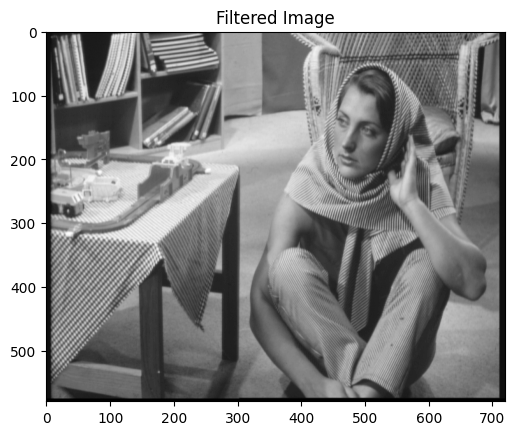

In [19]:
from PIL import Image
import cv2
from scipy.ndimage import gaussian_filter, convolve
h = np.array([[0, 1/6, 0], [1/6, 1/3, 1/6], [0, 1/6, 0]])
h = h / np.sum(h)  # Normalize the filter

original_image = Image.open('barbara.gif').convert('L')
b = np.array(original_image)

plt.imshow(b, cmap='gray')
plt.title('Original Image')
plt.show()

#h = fspecial_disk(radius=8)

#h = np.array([[0, -1, 0],
#              [-1, 5, -1],
#              [0, -1, 0]])

h1 = cv2.filter2D(b, -1, h)

# Display the filtered image
plt.imshow(h1, cmap='gray')
plt.title('Filtered Image')
plt.show()

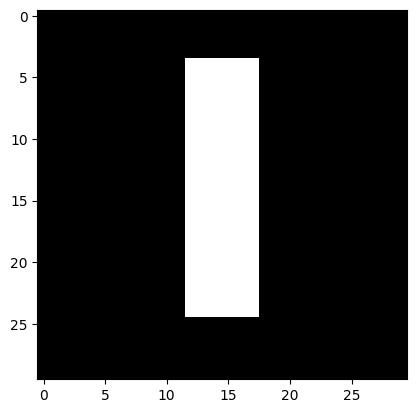

0.0
126.0


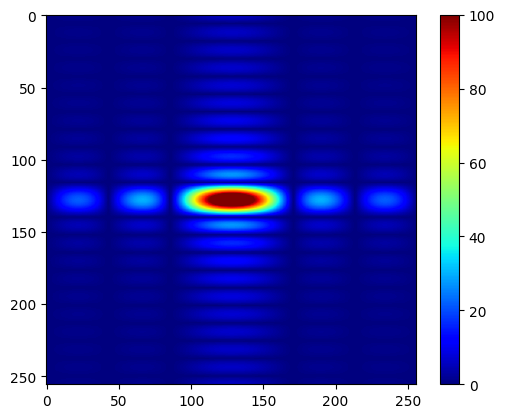

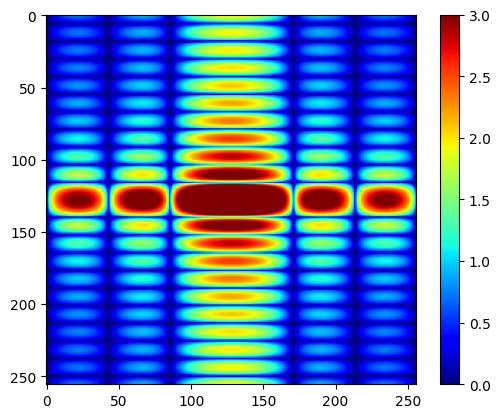

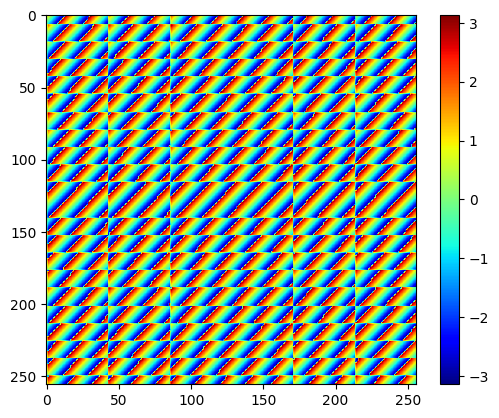

In [7]:
#spect.m
# imagen de un rectangulo
f = np.zeros((30, 30))
f[4:25, 12:18] = 1
plt.imshow(f, cmap='gray')
plt.show()

F = np.fft.fft2(f, (256, 256))
F = np.fft.fftshift(F)  # Center FFT

print(np.min(np.abs(F))) 
print(np.max(np.abs(F)))  

#espectro
plt.figure()
plt.imshow(np.abs(F), cmap='jet', vmin=0, vmax=100)
plt.colorbar()
plt.show()

#espectro es con logaritmo, realsa lo que no se ve tanto
plt.figure()
plt.imshow(np.log(1 + np.abs(F)), cmap='jet', vmin=0, vmax=3)
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(np.angle(F), cmap='jet', vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.show()

In [8]:
def downsampling(I, m, filter_on=False):
    # Get the dimensions of the input image
    N, M = I.shape
    # Apply ideal filter
    w = 1 / m
    F = np.fft.fftshift(np.fft.fft2(I))
    if filter_on:
        for i in range(N):
            for j in range(M):
                r2 = (i - round(N / 2))**2 + (j - round(M / 2))**2
                
                if r2 > round((N / 2 * w)**2):
                    F[i, j] = 0 #a partir de cierto radio, el espectro va con 0
    
    Idown = np.real(np.fft.ifft2(np.fft.fftshift(F)))
    #downsample
    Idown = cv2.resize(Idown, (N // m, M // m), interpolation=cv2.INTER_NEAREST)
    return Idown

def upsampling(I, m):
    N, M = I.shape
    
    # Create an empty output image
    Iup = np.zeros((m * N, m * M))
    
    # Expand input image
    for i in range(N):
        for j in range(M):
            Iup[m * i:m * (i + 1), m * j:m * (j + 1)] = I[i, j]
    N, M = Iup.shape
    w = 1 / m
    F = np.fft.fftshift(np.fft.fft2(Iup))
    
    for i in range(N):
        for j in range(M):
            r2 = (i - round(N / 2))**2 + (j - round(M / 2))**2
            if r2 > round((N / 2 * w)**2):
                F[i, j] = 0
    
    Iup = (m**2) * np.abs(np.fft.ifft2(np.fft.fftshift(F)))
    
    return Iup

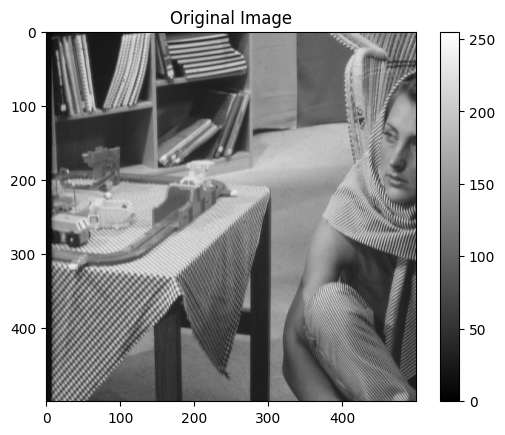

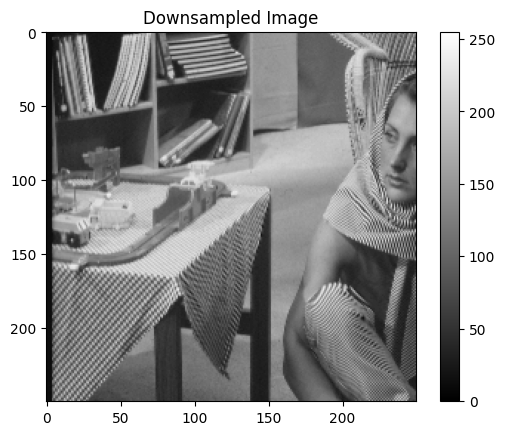

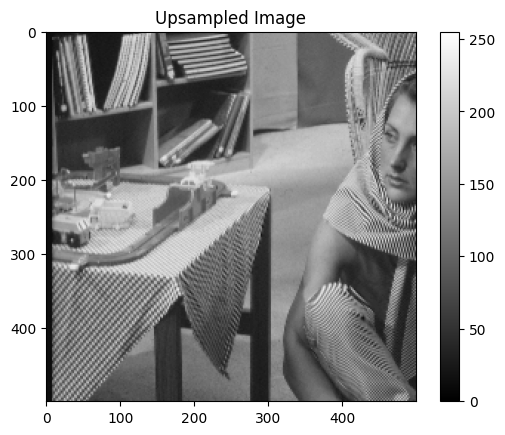

In [22]:

original_image = Image.open('barbara.gif').convert('L')
b = np.array(original_image)

# Crop the image to 500x500
f1 = b[:500, :500]

# Define the downsampling factor 'm'
m = 2

f2 = downsampling(f1, m)
# f2 = downsampling(f1, m)
# Perform upsampling
f3 = upsampling(f2, m)

# Display the images
plt.figure()
plt.imshow(f1, cmap='gray', vmin=0, vmax=255)
plt.title('Original Image')
plt.colorbar()

plt.figure()
plt.imshow(f2, cmap='gray', vmin=0, vmax=255)
plt.title('Downsampled Image')
plt.colorbar()

plt.figure()
plt.imshow(f3, cmap='gray', vmin=0, vmax=255)
plt.title('Upsampled Image')
plt.colorbar()

plt.show()

In [10]:
!pip install imageio opencv-python

In [48]:
original_image = Image.open('barbara.gif').convert('L')
b = np.array(original_image)
ysize, xsize = b.shape
video_size = (xsize, ysize)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
mov_pics = cv2.VideoWriter('aliasing_pics.avi', fourcc, 10, video_size, isColor=False)
mov_specs = cv2.VideoWriter('aliasing_specs.avi', fourcc, 10, video_size, isColor=False)
for xshrink in reversed(range(0, 601, 5)):
    desiredxsize = xsize - xshrink
    scale_shrink = desiredxsize / xsize

    if scale_shrink == 1:
        new_xsize = 1
        new_ysize = 1
    else:
        # Resize the image using cv2.resize
        new_xsize = int(xsize * (1 - scale_shrink))
        new_ysize = int(ysize * (1 - scale_shrink))
    f2 = cv2.resize(b, (new_xsize, new_ysize))
    f3 = cv2.resize(f2, (xsize, ysize))
    Fd = np.fft.fftshift(np.log(1 + np.abs(np.fft.fft2(f3))))
    xshrink
    fr = (f3 / np.max(f3) * 255).astype(np.uint8)
    Fdr = (Fd / np.max(Fd) * 255).astype(np.uint8)
    mov_pics.write(fr)
    mov_specs.write(Fdr)

mov_pics.release()
mov_specs.release()